# MRI Brain Tumor Segmentation

In this project, we will segment a brain tumor in MRI Images.

We will use `ResUNet Architecture` for the segmentation.

Also We will use `PyTorch`.

Dataset: [Brain MRI Segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation) 

We will follow this order:
1. Get data
2. Create datasets and dataloaders
3. Create Model
4. Train Model
5. Save Model
6. Evaluate and Visualize the model

## 1. Get Data

Download the data with following command from the command line.
```
!kaggle datasets download -d dmateuszbuda/lgg-mri-segmentation
```

**Note**: You may need to install and configure `kaggle` before downloading the data.

It will download the data with filename `lgg-mri-segmentation.zip`

We have to extract the data and set it up to create our datasets and dataloaders.

In [49]:
from pathlib import Path
from zipfile import ZipFile

data_path = Path('data')
mri_data_path = data_path/'mri_brain_tumor'

if mri_data_path.is_dir():
    print(f'{mri_data_path} already exists!')
else:
    mri_data_path.mkdir(parents=True, exist_ok=True)
    print(f'{mri_data_path} folders created')

zip_file_name = 'lgg-mri-segmentation.zip'

with ZipFile(zip_file_name, 'r') as zipfile:
    print('extracting...')
    zipfile.extractall(mri_data_path)
    print('extracted.')

data/mri_brain_tumor already exists!
extracting...
extracted.


In [50]:
import pandas as pd
import numpy as np

import torch
import torchvision

In [51]:
# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [52]:
# check datasets
brain_df = pd.read_csv('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/data.csv')
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

From the data we can see that we have total of `110` patients. 

That means there are images of `110` patients in the data.

In [53]:
import os
import random

all_imgs = list(mri_data_path.glob('*/*/*/*'))

# lets select random 5 images to see how the paths look like
random.seed(42) # seeding for reproducibility
random_samples = random.sample(all_imgs, k=5)

random_samples

[PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_7_mask.tif'),
 PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_39.tif'),
 PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_19_mask.tif'),
 PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_20.tif'),
 PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_13.tif')]

We can see that some images are ending with `mask.tif` and some are not ending with that.

That means we have images and their respective mask in the data.

Let's visualize and see.

Lets take the `2nd data` from the random sample:

`PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_39.tif')`


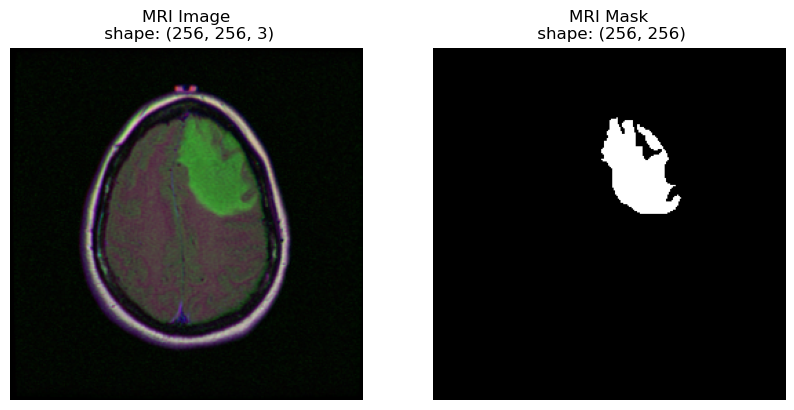

In [54]:
from PIL import Image
import matplotlib.pyplot as plt

# load the image
random_img = random_samples[1]
img = Image.open(random_img)

# get img folder
img_folder_path = random_img.parent

# getting just the name of the image
img_name = random_img.stem

# adding _mask in the image name to get the mask of the image
mask_name = f"{img_name.split('.tif')[0]}_mask.tif"

# adding together the img folder and the name of the mask to get the full path
# of the mask
mask_img_path = img_folder_path/mask_name

# loading the mask image
mask_img = Image.open(mask_img_path)

# turn the images(img and mask) into array before visualizing
img_asarray = np.asarray(img)
mask_img_asarray = np.asarray(mask_img)

# let's visualize the img and its mask

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(img_asarray)
plt.title(f'MRI Image\n shape: {img_asarray.shape}')
plt.axis(False)

plt.subplot(1,2,2)
plt.imshow(mask_img_asarray, cmap='gray') # we should do color map (cmap=gray) because by default matplotlib doesn't show grayscale images
plt.title(f'MRI Mask\n shape: {mask_img_asarray.shape}') # to see the shape of the image
plt.axis(False);


Beaufiful!

Now we have a image and its mask, and we know how the path to those image and mask look like.
Image: 'data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/`TCGA_DU_6401_19831001_39.tif`'

Mask: 'data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/`TCGA_DU_6401_19831001_39_mask.tif`'

### 1.1 Lets understand our data more.

We have to first divide our data to images and its masks.

We can do that by creating a function where we send the path to the images folder and it will return image paths and mask paths.

In [55]:
from typing import Tuple, List
import fnmatch 

def get_imgs_and_masks(mri_data_path:str) :# -> Tuple[List, List]:
    all_images = list(mri_data_path.glob("*/*.tif")) # both img and masks
    pattern_for_mask = '*_mask.tif'

    imgs = []
    masks =  []
    
    # images are all paths that doesn't match the patten
    for img_path in all_images:
        # loop through only if the mask patten is not matched
        if not fnmatch.fnmatch(img_path, pattern_for_mask):
            imgs.append(img_path)
    
            # get img folder
            img_folder_path = img_path.parent
            
            # getting just the name of the image
            img_name = img_path.stem
            
            # adding _mask in the image name to get the mask of the image
            mask_name = f"{img_name.split('.tif')[0]}_mask.tif"
            
            # adding together the img folder and the name of the mask to get the full path
            # of the mask
            mask_img_path = img_folder_path/mask_name
    
            # append the mask img path to the masks list
            masks.append(mask_img_path)

    return imgs, masks
    
mri_data_path = Path('data/mri_brain_tumor/kaggle_3m')
imgs, masks = get_imgs_and_masks(mri_data_path)
imgs[1], masks[1]
# print(imgs)

(PosixPath('data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8.tif'),
 PosixPath('data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8_mask.tif'))

Let's see how many imgs and masks we have:

In [56]:
len(imgs), len(masks)

(3929, 3929)

Great!

We have `3929` imgs and masks pairs.

Lets visualize couple of pairs.

Because I like visualizing!!!

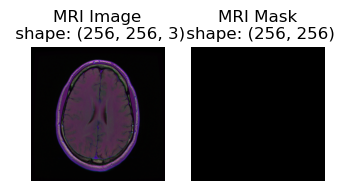

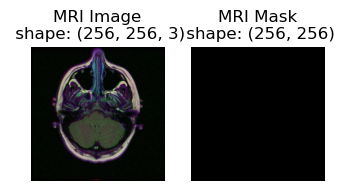

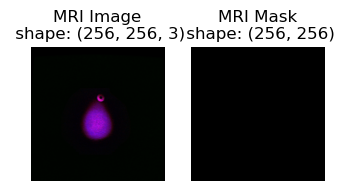

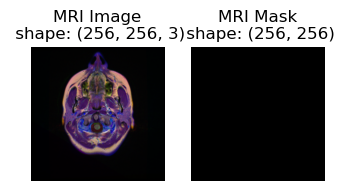

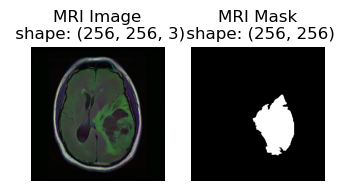

In [57]:
from PIL import Image
import matplotlib.pyplot as plt

# Lets get random 5 samples from the imgs
# comment random seed to see different images
random.seed(42) # to make it reproducible
random_indexes = random.sample(range(len(imgs)), k=5)
random_indexes

for idx in range(len(random_indexes)):
    img = imgs[random_indexes[idx]]
    mask = masks[random_indexes[idx]]

    img = Image.open(img)
    mask = Image.open(mask)

    # turn the images(img and mask) into array before visualizing
    img_asarray = np.asarray(img)
    mask_img_asarray = np.asarray(mask)
    
    # let's visualize the img and its mask
    
    plt.figure(figsize=(10,8))
    
    plt.subplot(2,5,1)
    plt.imshow(img_asarray)
    plt.title(f'MRI Image\n shape: {img_asarray.shape}')
    plt.axis(False)
    
    plt.subplot(2,5,2)
    plt.imshow(mask_img_asarray, cmap='gray') # we should do color map (cmap=gray) because by default matplotlib doesn't show grayscale images
    plt.title(f'MRI Mask\n shape: {mask_img_asarray.shape}') # to see the shape of the image
    plt.axis(False);
    

Amazing!!!

We just visualized the data we have - Image and its corresponding masks.

We can see that some of them do not have masks in them.

This is because, the images that have corresponing masks, are the MRI images with Brain tumor.

And the images that do not have corresponding masks, are the MRI image without Brain tumor.

In our above visualization, `top 4 are the one with no Brain Tumor` and the `one at the botton has Brain Tumor`.

**Now Lets create a DataFrame that contains `image ID`, `Image path`, `Mask path`, and `whether it has tumor`**


In [58]:
from PIL import Image
# loop through all the imgs
img_ids = []
has_tumor = []
for idx in range(len(imgs)):
    ids = imgs[idx].stem.split('.tif')[0]
    img_ids.append(ids)

    # check pixel in mask, if the pixel is more than 0, then it has tumor
    # because masks with no tumor is a blank image - image with 0 pixel values
    mask = Image.open(masks[idx])
    mask_asarray = np.asarray(mask)
    is_tumor = np.where(np.max(mask_asarray)>0, 1, 0)
    has_tumor.append(is_tumor)
has_tumor[:3]
    

[array(0), array(0), array(1)]

In [59]:
data_dataframe = pd.DataFrame({
    'ids': img_ids,
    'img_paths': imgs,
    'mask_paths': masks,
    'is_tumor': has_tumor
}).reset_index(drop=True)

data_dataframe.head()

,ids,img_paths,mask_paths,is_tumor
0,TCGA_CS_6667_20011105_9,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,0
1,TCGA_CS_6667_20011105_8,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,0
2,TCGA_CS_6667_20011105_16,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,1
3,TCGA_CS_6667_20011105_17,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,1
4,TCGA_CS_6667_20011105_15,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,1


Beautiful!!! 
We got our dataframe.

Now we will use this dataframe to create our dataset and dataloaders.

Lets do it.

## 2. Create datasets and dataloaders

Lets setup our cutom datasets for our segmentation task.

### 2.1 Datasets

In [60]:
from torch.utils.data import Dataset
from PIL import Image
from typing import Tuple

class CustomSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transforms):
        self.image_paths =  image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms

    def __len__(self) -> int:
        """
        Returns the length of the dataset
        """
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            image and mask at given idx
        """
        # get image and mask path for the idx
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # load the image and mask
        img = Image.open(image_path)
        mask = Image.open(mask_path)

        # apply the transform if transform exists
        if self.transforms:
            img = self.transforms(img)
            mask = self.transforms(mask)

        return img, mask

Sweet!

Now that we have our `CustomSegmentationDataset` function.

Lets split our image directories into train and test directories.

We'll use `80:20` split.

In [61]:
data_dataframe.columns

Index(['ids', 'img_paths', 'mask_paths', 'is_tumor'], dtype='object')

In [62]:
from sklearn.model_selection import train_test_split

train_img_dir, test_img_dir, train_mask_dir, test_mask_dir = train_test_split(data_dataframe['img_paths'].tolist(), # we should do to list here to make sure wereset the index
                                                                                    data_dataframe['mask_paths'].tolist(),
                                                                                    test_size=0.2, 
                                                                                    random_state=42)
print(f'Train image, mask size: {len(train_img_dir), len(train_mask_dir)}')
print(f'Test image, mask size: {len(test_img_dir), len(test_mask_dir)}')                                              

Train image, mask size: (3143, 3143)
Test image, mask size: (786, 786)


Now that we have, train and test directories, lets create a transform to load the dataset.

In [374]:
from torchvision import transforms

RESIZE_SIZE = (572,572)

train_transforms = transforms.Compose([
    transforms.Resize(size=RESIZE_SIZE),
    transforms.RandomHorizontalFlip(p=-.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=RESIZE_SIZE),
    transforms.ToTensor()
])

Great.

Now that we have a train and test transforms, we can pass them to load our dataset.

In [375]:
train_dataset = CustomSegmentationDataset(train_img_dir, train_mask_dir, transforms=train_transforms)
test_dataset = CustomSegmentationDataset(test_img_dir, test_mask_dir, transforms=test_transforms)

len(train_dataset), len(test_dataset)

(3143, 786)

Our dataset will return an image and its corresponding mask.

In [376]:
img, mask = next(iter(train_dataset))
img, mask

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

Now lets display random images from our custom dataset.

we will get 10 random images and display them.

we will:
1. Get random 10 indexes from the dataset.
2. Setup matplotlib.
3. Loop through the random images and plot them in matplotlib.
4. Make sure the dimension of our images line up with matplotlib
5. Plot the adjusted image and masks

In [377]:
train_dataset

In [378]:
import random

def plot_random_images(dataset: torch.utils.data.Dataset,
                       n: int = 10,
                       seed: int = None):

    if seed:
        random.seed(42)
    
    # 1. Get random 10 indexes from the dataset
    random_sample_idxs = random.sample(range(len(dataset)), k = n)
    random_sample_idxs
    
    # 2. setup matplotlib
    plt.figure(figsize=(16,8))
    
    # 3. Loop through the random images and plot them in matplotlib
    for i, idx in enumerate(random_sample_idxs):
        img, mask = dataset[idx]
    
        # 4. adjusting images tensor dimensions for matplotlib
        img_adjusted = img.permute(1,2,0)
        mask_adjusted = mask.permute(1,2,0)
    
        # 5. plot the adjusted image and masks
        plt.subplot(1, n, i+1)
        plt.imshow(img_adjusted)
        plt.title(f'img')
        
        plt.subplot(2, n, i+1)
        plt.imshow(mask_adjusted)
        plt.title(f'mask')

Great!

Now we have a function to plot random images

lets plot random train and test data.

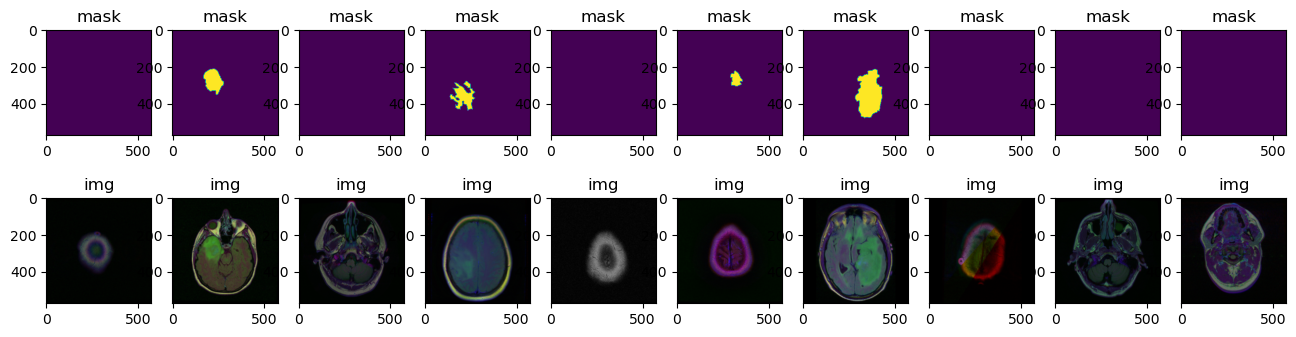

In [379]:
# plot random 10 train dataset
plot_random_images(dataset=train_dataset, n=10, seed=42)

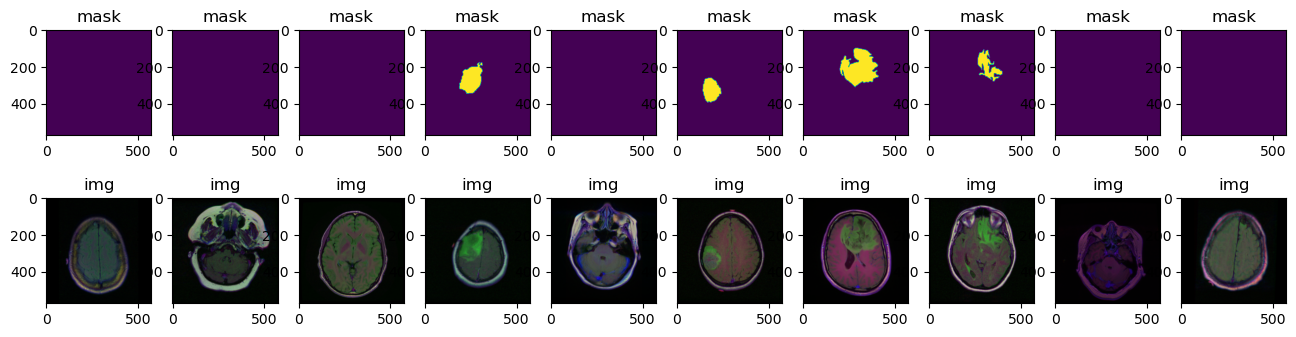

In [380]:
# plot random 10 test dataset
plot_random_images(dataset=test_dataset, n=10, seed=42)

Great!

Now our dataset is ready.
Lets create a `DataLoader` now

### 2.2 DataLoader

Lets turn our dataset into a dataloader now.

In [381]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = 0 # set 0 to disable multiprocessing 

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers = NUM_WORKERS)

In [382]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x15566fb50>,
 <torch.utils.data.dataloader.DataLoader at 0x155888700>)

In [383]:
img, mask = next(iter(train_dataloader))
img.shape, mask.shape

(torch.Size([32, 3, 572, 572]), torch.Size([32, 1, 572, 572]))

## 3. Create a Model

Now that we have our datasets and dataloaders, we can start building our model.

We are doing segmentation here.

There are multiple algorithms available that can help us to segmentation.

We will first start with `UNet Algorithm`. 
- First we will create the algorithm by ourself and
- then we will use Transfer learning and utilize Torchvision Models.

### 3.1 Model 0: UNet

[Unet](https://paperswithcode.com/paper/u-net-convolutional-networks-for-biomedical) is a convolutional neural network architecture for biological image segmentation. Specifically for semantic segmentation. The architecture looks like `U`, hence the name.
![](UnetArchitecture.png)

It consists of the repeated application of `two 3x3 convolutions (unpadded convolutions)`, each `followed by a rectified linear unit (ReLU)` and `a 2x2 max pooling operation with stride 2` for downsampling

This [blog](https://amaarora.github.io/posts/2020-09-13-unet.html) helped me a lot to implement this model.

#### 3.1.1 Blocks
Lets First create the block. 

A `Block in UNet` is:

2 convolutions each followed by ReLU.

Both convolution layers have kernel size of (3,3) and 0 padding.

In [384]:
from torch import nn

# lets create blocks of the Unet
class Block(nn.Module):
    def __init__(self,
                 input_shape:int,
                 output_shape:int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=output_shape,
                      kernel_size=(3,3),
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=output_shape,
                      out_channels=output_shape,
                      kernel_size=(3,3),
                      padding=0),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

Lets see how our block words now.

In [385]:
block = Block(1, 64)

# sample input
x = torch.randn(1,1, 572, 572) # we are checking (572x572) because thats the image size paper mentioned

# output of the block
block(x).shape

torch.Size([1, 64, 568, 568])

the output size `torch.Size([1, 64, 568, 568])` matches with the output size given in the architecture.

We are on a right track.

#### 3.1.2 Encoder

Encoder is the collection of blocks with different inputs and outputs with  a max pool layer in between them.

If we look at the architecture we can see their input_size and output_size.
- Block 1: (3, 64)
- Block 2: (64, 128) -> (64, 64*2)
- Block 3: (128, 256) -> (64*2, 64*4)
- Block 4: (256, 512) -> (64*4, 64*8)
- Block 5: (512, 1024) -> (64*8, 64*16)

Lets create a Encoder with those blocks included.

In [386]:
class Encoder(nn.Module):
    def __init__(self,
                 input_size:int=3,
                 initial_output_size: int=64):
        super().__init__()
        self.block_1 = Block(input_size, initial_output_size) # Block 1: (3, 64)
        self.block_2 = Block(initial_output_size, initial_output_size*2) # Block 2: (64, 128) -> (64, 64*2)
        self.block_3 = Block(initial_output_size*2, initial_output_size*4) # Block 3: (128, 256) -> (64*2, 64*4)
        self.block_4 = Block(initial_output_size*4, initial_output_size*8) # Block 4: (256, 512) -> (64*4, 64*8)
        self.block_5 = Block(initial_output_size*8, initial_output_size*16) # Block 5: (512, 1024) -> (64*8, 64*16)
        
        self.max_pool = nn.MaxPool2d(
            kernel_size=(2,2),
            stride=2
        )

    def forward(self, x: torch.Tensor):
        block_outputs = []
        x = self.block_1(x)
        block_outputs.append(x) # appending output of block 1
        x = self.max_pool(x)

        x = self.block_2(x)
        block_outputs.append(x) # appending output of block 2
        x = self.max_pool(x)
        
        x = self.block_3(x)
        block_outputs.append(x) # appending output of block 3
        x = self.max_pool(x)
        
        x = self.block_4(x)
        block_outputs.append(x) # appending output of block 4
        x = self.max_pool(x)
        
        x = self.block_5(x)
        block_outputs.append(x) # appending output of block 5

        return block_outputs

We are saving the block outputs because we use this block outputs as a input for corresponsing block from the decoder.

In [387]:
encoder = Encoder(3,64)

# input image
x    = torch.randn(1, 3, 572, 572)
# encoder_output = encoder(x)
# encoder_output.shape

encoder_block_outputs = encoder(x)
encoder_block_outputs[::-1][0].size() # last block size


torch.Size([1, 1024, 28, 28])

Let's check the output of our each blocks.

We can use `torchinfo` for this.

In [388]:
from torchinfo import summary

summary(model=encoder,
        input_size=(1,3,572,572),
        col_names=['input_size', 'output_size']
       )

Layer (type:depth-idx)                   Input Shape               Output Shape
Encoder                                  [1, 3, 572, 572]          [1, 64, 568, 568]
├─Block: 1-1                             [1, 3, 572, 572]          [1, 64, 568, 568]
│    └─Sequential: 2-1                   [1, 3, 572, 572]          [1, 64, 568, 568]
│    │    └─Conv2d: 3-1                  [1, 3, 572, 572]          [1, 64, 570, 570]
│    │    └─ReLU: 3-2                    [1, 64, 570, 570]         [1, 64, 570, 570]
│    │    └─Conv2d: 3-3                  [1, 64, 570, 570]         [1, 64, 568, 568]
│    │    └─ReLU: 3-4                    [1, 64, 568, 568]         [1, 64, 568, 568]
├─MaxPool2d: 1-2                         [1, 64, 568, 568]         [1, 64, 284, 284]
├─Block: 1-3                             [1, 64, 284, 284]         [1, 128, 280, 280]
│    └─Sequential: 2-2                   [1, 64, 284, 284]         [1, 128, 280, 280]
│    │    └─Conv2d: 3-5                  [1, 64, 284, 284]         [

The shape of our output matches with the architecture diagram. 

You can look at each block size and check if it matches with the architecture diagram from the paper.

---

Great. We just implement the half of the architecture - `the Encoder`

Now lets do other half - `the Decoder`

#### 3.1.3 Decoder

Implementing Decoder is a tricky part here. But, if you follow the paper, and follow this tutorial, you will figure out how to implement it.

Let's start with what is written in the paper about Decoder. You can find this in section 2. Network Architecture
> *Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution.*

We will go from 1024 -> 64, opposite of what we did in Encoder.

- Block 1: (1024, 512)
- Block 2: (512, 256) -> (64, 64*2)
- Block 3: (256, 128) -> (642, 644)
- Block 4: (128, 64) -> (644, 648)

that means we will go from 1024 input_size to 64 output_size.

From  the paper description we need `up-convolution` and decoder `blocks` - 2blocks with ReLU in between, same as the encoder.

In PyTorch, `nn.ConvTranspose2d` is used to do `up-convolution`.

Furthermore, we also have `a concatenation with the correspondingly cropped feature map from the contracting path`


In [389]:
from torch import nn

class Decoder(nn.Module):
    """Decoder for UNet architecture
    """
    def __init__(self, 
                 input_size:int,
                 initial_output_size:int, 
                 encoder_blocks_outputs):
        super().__init__()
        self.encoder_block_outputs = encoder_blocks_outputs
        
        self.up_convolution_1 = nn.ConvTranspose2d(
                in_channels=input_size,
                out_channels=initial_output_size,
                kernel_size=(2,2),
                stride=(2,2)
            )
        self.block_1= Block(input_shape=input_size,
                            output_shape=initial_output_size)
        
        self.up_convolution_2 = nn.ConvTranspose2d(
                in_channels=initial_output_size,
                out_channels=initial_output_size//2,
                kernel_size=(2,2),
                stride=(2,2)
            )
        self.block_2 = Block(input_shape=initial_output_size,
                            output_shape=initial_output_size//2)
        
        self.up_convolution_3 = nn.ConvTranspose2d(
                in_channels=initial_output_size//2,
                out_channels=initial_output_size//4,
                kernel_size=(2,2),
                stride=(2,2)
            )
        self.block_3= Block(input_shape=initial_output_size//2,
                            output_shape=initial_output_size//4)
        
        self.up_convolution_4 = nn.ConvTranspose2d(
                in_channels=initial_output_size//4,
                out_channels=initial_output_size//8,
                kernel_size=(2,2),
                stride=(2,2)
            )
        self.block_4= Block(input_shape=initial_output_size//4,
                            output_shape=initial_output_size//8)
        
    
    def forward(self, x):
        # for block 1
        x_up_convolution_1 = self.up_convolution_1(x)
        cropped_encoder_block_1 = self.crop(self.encoder_block_outputs[0], x_up_convolution_1)
        # concatenate the output of x_up_convolution and the cropped encoder
        # print(cropped_encoder_block_1.shape)
        x_concatenated = torch.cat([x_up_convolution_1, cropped_encoder_block_1], dim=1)
        # print(x_concatenated.shape)
        block_1_output = self.block_1(x_concatenated)

        # for block 2
        x_up_convolution_2 = self.up_convolution_2(block_1_output)
        cropped_encoder_block_2 = self.crop(self.encoder_block_outputs[1], x_up_convolution_2)
        # concatenate the output of x_up_convolution and the cropped encoder
        x_concatenated = torch.cat([x_up_convolution_2, cropped_encoder_block_2], dim=1)
        block_2_output = self.block_2(x_concatenated)
        
        # for block 3
        x_up_convolution_3 = self.up_convolution_3(block_2_output)
        cropped_encoder_block_3 = self.crop(self.encoder_block_outputs[2], x_up_convolution_3)
        # concatenate the output of x_up_convolution and the cropped encoder
        x_concatenated = torch.cat([x_up_convolution_3, cropped_encoder_block_3], dim=1)
        block_3_output = self.block_3(x_concatenated)
        
        # for block 4
        x_up_convolution_4 = self.up_convolution_4(block_3_output)
        cropped_encoder_block_4 = self.crop(self.encoder_block_outputs[3], x_up_convolution_4)
        # concatenate the output of x_up_convolution and the cropped encoder
        x_concatenated = torch.cat([x_up_convolution_4, cropped_encoder_block_4], dim=1)
        block_4_output = self.block_4(x_concatenated)
        
        # return block_4_output
        return block_4_output

    def crop(self, encoder_block_output, x_up_convolution):
        _,_,H,W = x_up_convolution.shape
        cropped_encoder_block = torchvision.transforms.CenterCrop([H,W])(encoder_block_output)

        return cropped_encoder_block

Lets check if our decoder works.

We will start with the `output from our encoder` and see what we get.

In [390]:
decoder = Decoder(input_size=1024, initial_output_size=512, encoder_blocks_outputs=encoder_block_outputs[::-1][1:])
x = torch.randn(1, 1024, 28, 28)
decoder(x).shape

torch.Size([1, 64, 388, 388])

This shape matches the shape with the output of the UNet architecture.

Lets see the output of our indivisual blocks of the decoder. We can do that using `torchinfo`.

In [391]:
from torchinfo import summary

summary(model=decoder,
        input_size=(1, 1024, 28, 28),
        col_names=['output_size']
       )

Layer (type:depth-idx)                   Output Shape
Decoder                                  [1, 64, 388, 388]
├─ConvTranspose2d: 1-1                   [1, 512, 56, 56]
├─Block: 1-2                             [1, 512, 52, 52]
│    └─Sequential: 2-1                   [1, 512, 52, 52]
│    │    └─Conv2d: 3-1                  [1, 512, 54, 54]
│    │    └─ReLU: 3-2                    [1, 512, 54, 54]
│    │    └─Conv2d: 3-3                  [1, 512, 52, 52]
│    │    └─ReLU: 3-4                    [1, 512, 52, 52]
├─ConvTranspose2d: 1-3                   [1, 256, 104, 104]
├─Block: 1-4                             [1, 256, 100, 100]
│    └─Sequential: 2-2                   [1, 256, 100, 100]
│    │    └─Conv2d: 3-5                  [1, 256, 102, 102]
│    │    └─ReLU: 3-6                    [1, 256, 102, 102]
│    │    └─Conv2d: 3-7                  [1, 256, 100, 100]
│    │    └─ReLU: 3-8                    [1, 256, 100, 100]
├─ConvTranspose2d: 1-5                   [1, 128, 200, 200]
├

Lets put Encoder and Decoder together and make our UNet Architecture.

We have to add final head that would do the final segmentation.

In [392]:
from typing import Tuple
class UNet(nn.Module):
    """
    """
    def __init__(self, 
                 encoder_input_size: int,
                 encoder_initial_output_size: int,
                 decoder_input_size: int,
                 decoder_initial_output_size: int,
                 num_class:int=1
                ):
        super().__init__()
        self.encoder = Encoder(encoder_input_size, encoder_initial_output_size)
        self.decoder_input_size = decoder_input_size
        self.decoder_initial_output_size = decoder_initial_output_size
        
        self.head = nn.Conv2d(
            in_channels=decoder_initial_output_size//8,
            out_channels=num_class,
            kernel_size=1
        )
        
    def forward(self, x):
        encoder_output_blocks = self.encoder(x)
        decoder = Decoder(input_size=self.decoder_input_size,
                          initial_output_size=self.decoder_initial_output_size, 
                          encoder_blocks_outputs=encoder_output_blocks[::-1][1:]
                         )
        
        x = decoder(encoder_output_blocks[::-1][0])

        return x

In [393]:
from torchinfo import summary

model = UNet(3,64,1024,512)

summary(model=model,
        input_size=(1, 3, 572, 572),
        col_names=['output_size'],
        depth=5
       )

Layer (type:depth-idx)                   Output Shape
UNet                                     [1, 64, 388, 388]
├─Encoder: 1-1                           [1, 64, 568, 568]
│    └─Block: 2-1                        [1, 64, 568, 568]
│    │    └─Sequential: 3-1              [1, 64, 568, 568]
│    │    │    └─Conv2d: 4-1             [1, 64, 570, 570]
│    │    │    └─ReLU: 4-2               [1, 64, 570, 570]
│    │    │    └─Conv2d: 4-3             [1, 64, 568, 568]
│    │    │    └─ReLU: 4-4               [1, 64, 568, 568]
│    └─MaxPool2d: 2-2                    [1, 64, 284, 284]
│    └─Block: 2-3                        [1, 128, 280, 280]
│    │    └─Sequential: 3-2              [1, 128, 280, 280]
│    │    │    └─Conv2d: 4-5             [1, 128, 282, 282]
│    │    │    └─ReLU: 4-6               [1, 128, 282, 282]
│    │    │    └─Conv2d: 4-7             [1, 128, 280, 280]
│    │    │    └─ReLU: 4-8               [1, 128, 280, 280]
│    └─MaxPool2d: 2-4                    [1, 128, 140, 

In [396]:
model = UNet(3,64,1024,512)
x    = torch.randn(1, 3, 572, 572)
model(x).shape

torch.Size([1, 64, 388, 388])

Great!

The output shape of the model matches with the output shape from the architecture.

Now its time to `train our model`.

## 4. Train Model

Now lets create a training and testing loop for our UNet model.

In [ ]:
from tqdm.auto import tqdm

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

EPOCHS = 5
BATCH_SIZE=32

for epoch in tqdm(range(EPOCHS)):
    # train loop
    for batch, (X,y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        # forward
        y_pred_logits = model(X)
        loss = loss_fn(y_pred_logits, y)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # test loop

## 5. Save Model

## 6. Evaluate and Visualize the model
